In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

In [6]:
for x,y in zip(Xtr[:8], Ytr[:8]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d


In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

class Flatten:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, (T // self.n), (C * self.n))
        if x.shape[1] == 1: x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42)

In [9]:
n_embed = 24
n_hidden = 128
model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Flatten(2), Linear(n_hidden*2,  n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Flatten(2), Linear(n_hidden*2,  n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
  
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
  
    for p in parameters:
        p.grad = None
    loss.backward()
  
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8806
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


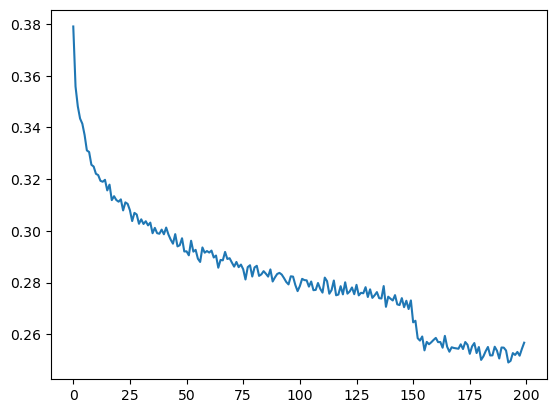

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [12]:
for layer in model.layers:
  layer.training = False

In [13]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690284252166748
val 1.9936524629592896


In [14]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

aiyanah.
giusopf.
lorron.
roger.
rhyitte.
christell.
jedmccee.
kelipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jeniyah.
glatipe.
manaswi.
yeslee.
stephania.
